# Reconstruct 10 minute OOI DAS data using trained Random Fourier Feature Network

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import time
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "3"
import torch
from torch.utils.data import DataLoader
from torch.nn import MSELoss

masked_cmap = matplotlib.cm.bwr
masked_cmap.set_bad('black', 0.5)

# import seaborn as sns
# sns.set(font_scale=1.4)
# sns.set_style("darkgrid")

# import models in ../scripts
import sys
sys.path.append("../scripts/")
from models import RandomFourierFeatureNetwork
from datasets import OOIDASDataset

from scipy.signal import butter, filtfilt
from scipy.signal import correlate

/home/niyiyu/anaconda3/envs/seisml/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## load data and weights (state dict)

In [ ]:
B = np.load("../datasets/test_OOI_10min_rffn_features.npy")
state_dict = torch.load("../datasets/test_OOI_10min_rffn_weights.pt")

In [5]:
t0 = time.time()
NX, NT = (6000, 6000)
t, x = np.meshgrid(np.arange(NT), np.arange(NX))
T = t/(NT-1); 
X = x/(NX-1);

n_feature = 196

print("Initialize random fourier encoding matrix.")
print("Encoding. This is the computation intensive part. May take some time.")
# for numpy
# Bv = np.concatenate([T.reshape([-1, 1]), X.reshape([-1, 1])], axis = -1)@B.T
# for torch
Bv = torch.matmul(torch.Tensor(np.concatenate([T.reshape([-1, 1]), X.reshape([-1, 1])], axis = -1)), 
                  torch.Tensor(B.T))

# print("Creating datasets.")
# for numpy
# inputs = np.concatenate([np.cos(2*np.pi*Bv), np.sin(2*np.pi*Bv)], axis = -1)
# outputs = TRAIN_DATA.reshape([-1, 1])

# for torch
inputs = torch.cat([torch.cos(2*torch.pi*Bv), torch.sin(2*torch.pi*Bv)], axis = -1)

# print(T.shape, X.shape)
print(f"Finished. takes %.3f sec" % (time.time() - t0))

Initialize random fourier encoding matrix.
Encoding. This is the computation intensive part. May take some time.
Finished. takes 5.163 sec


## defind model and load the weights

In [6]:
device = torch.device('cuda')
model = RandomFourierFeatureNetwork(n_feature, n_layers=3)
model.load_state_dict(state_dict)
model.to(device)

RandomFourierFeatureNetwork(
  (inputs): Linear(in_features=392, out_features=196, bias=True)
  (ln1): Linear(in_features=196, out_features=196, bias=True)
  (ln2): Linear(in_features=196, out_features=196, bias=True)
  (ln3): Linear(in_features=196, out_features=196, bias=True)
  (outputs): Linear(in_features=196, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [10]:
n_weights = 0
for i in model.parameters():
    n_weights += len(i.data.flatten())
print(f"have total {n_weights}")

have total 193061


## reconstruct

In [7]:
npiece = 10
len_piece = int(NX*NT/npiece)
predict = np.zeros(NX * NT)
for i in range(npiece):
    _gpu_predict = model(inputs[i*len_piece:(i+1)*len_piece, :].to(device))
    predict[i*len_piece:(i+1)*len_piece] = _gpu_predict.detach().cpu().numpy()[:, 0]
torch.cuda.empty_cache()
predict = predict.reshape(NX, NT)

([], [])

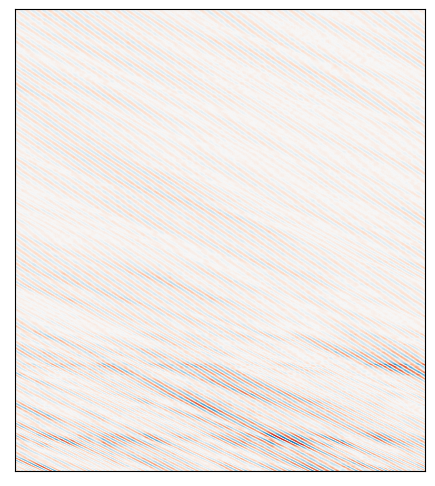

In [12]:
plt.figure(figsize = (18, 6))
# plt.subplot(1,3,1)
# plt.imshow(TRAIN_DATA, cmap = 'RdBu', aspect = 'auto', origin='lower', 
#            vmin = 0, vmax = 1)
# plt.xticks([]); plt.yticks([])
# # plt.title("original", fontsize = 20)

plt.subplot(1,3,2)
plt.imshow(predict, cmap = 'RdBu', aspect = 'auto', origin='lower', 
           vmin = 0, vmax = 1)
plt.xticks([]); plt.yticks([])
# plt.colorbar()
# plt.title("reconstruction", fontsize = 20)

# plt.subplot(1,3,3)
# plt.imshow(TRAIN_DATA - predict, cmap = 'RdBu', aspect = 'auto', origin='lower', vmin = -0.05, vmax = 0.05)
# plt.xticks([]); plt.yticks([])
# # plt.colorbar()
# plt.savefig("./figures/rffn_deep.pdf", bbox_inches = 'tight')